In [1]:
!nvidia-smi

Mon May 31 17:04:50 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 456.71       Driver Version: 456.71       CUDA Version: 11.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 166... WDDM  | 00000000:01:00.0  On |                  N/A |
| 29%   37C    P8    14W / 125W |    585MiB /  6144MiB |     18%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU  

In [2]:
cd /cv_study/landmark_kor

G:\cv_study\landmark_kor


In [3]:
import os
import glob

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [4]:
tf.__version__

'2.4.1'

In [5]:
train_df = pd.read_csv("./train.csv")
train_df.head()

,id,landmark_id
0,동탄_복합문화센터_057,114
1,동탄_복합문화센터_110,114
2,동탄_복합문화센터_016,114
3,동탄_복합문화센터_022,114
4,동탄_복합문화센터_052,114


In [6]:
train_df.shape

(88102, 2)

In [7]:
submission_df = pd.read_csv('./sample_submission.csv')
submission_df.head()

,id,landmark_id,conf
0,xlf1tgh2ih,1,1
1,68a3ot4osk,1,1
2,si2lek4u0a,1,1
3,rmtqxhipnv,1,1
4,2flmjdud0e,1,1


In [8]:
test_path = './test_set'
test_img_list = glob.glob(os.path.join(test_path, '*', '*.JPG'))
len(test_img_list)

37964

In [9]:
cat_df = pd.read_csv("./category.csv")
cat_df.head()

,landmark_id,landmark_name
0,0,금천구청
1,1,두리랜드
2,2,이대원 장군묘
3,3,성공회대학교
4,4,송상현공 동상


In [10]:
num_classes =  train_df['landmark_id'].nunique()
num_classes

1049

In [11]:
train_path = './train_set_img'
train_img_list = glob.glob(os.path.join(train_path, '*', '*', '*.JPG'))

In [12]:
len(train_img_list)

88102

In [13]:
train_img_df = pd.DataFrame(train_img_list, columns=['filepath'])
train_img_df['filename'] = train_img_df['filepath'].apply(lambda x: os.path.basename(x))
train_img_df['name'] = train_img_df['filename'].apply(lambda x: x.split('.JPG')[0].split('_')[:-1])
train_img_df['name'] = train_img_df['name'].apply(lambda x: '_'.join(x) if len(x)>1 else x[0])

In [14]:
train_img_df['id'] = train_img_df['filename'].apply(lambda x: x.split('.JPG')[0])

In [15]:
train_img_df.head()

,filepath,filename,name,id
0,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_002.JPG,G_챔피언스_파크_002.JPG,G_챔피언스_파크,G_챔피언스_파크_002
1,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_003.JPG,G_챔피언스_파크_003.JPG,G_챔피언스_파크,G_챔피언스_파크_003
2,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_004.JPG,G_챔피언스_파크_004.JPG,G_챔피언스_파크,G_챔피언스_파크_004
3,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_006.JPG,G_챔피언스_파크_006.JPG,G_챔피언스_파크,G_챔피언스_파크_006
4,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_007.JPG,G_챔피언스_파크_007.JPG,G_챔피언스_파크,G_챔피언스_파크_007


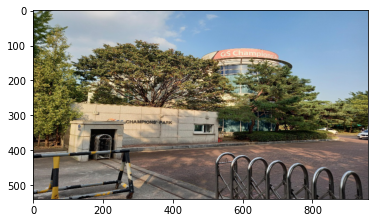

In [16]:
import matplotlib.pyplot as plt
import matplotlib.image as img
from PIL import Image

smp1 = img.imread(train_img_df['filepath'].values[0])
plt.imshow(smp1)
plt.show()

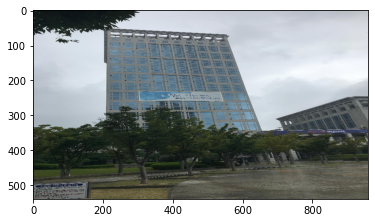

In [17]:
smpt = img.imread(test_img_list[0])
plt.imshow(smpt)
plt.show()

In [18]:
train_img_df = pd.merge(train_img_df, train_df, how='left', on = 'id')
train_img_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 88102 entries, 0 to 88101
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   filepath     88102 non-null  object
 1   filename     88102 non-null  object
 2   name         88102 non-null  object
 3   id           88102 non-null  object
 4   landmark_id  88102 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 4.0+ MB


In [19]:
train_img_df.head()

,filepath,filename,name,id,landmark_id
0,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_002.JPG,G_챔피언스_파크_002.JPG,G_챔피언스_파크,G_챔피언스_파크_002,644
1,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_003.JPG,G_챔피언스_파크_003.JPG,G_챔피언스_파크,G_챔피언스_파크_003,644
2,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_004.JPG,G_챔피언스_파크_004.JPG,G_챔피언스_파크,G_챔피언스_파크_004,644
3,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_006.JPG,G_챔피언스_파크_006.JPG,G_챔피언스_파크,G_챔피언스_파크_006,644
4,./train_set_img\경기도\G 챔피언스 파크\G_챔피언스_파크_007.JPG,G_챔피언스_파크_007.JPG,G_챔피언스_파크,G_챔피언스_파크_007,644


In [20]:
X, y = train_img_df['filepath'].values, train_img_df['landmark_id'].values
X_train_img , X_val_img, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y)
print(X_train_img.shape)
print(X_val_img.shape)

(70481,)
(17621,)


In [21]:
img_height=224
img_width=224
batch_size = 4

def resize_rescale(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    img_arr = tf.image.resize(img, [img_height, img_width])
    img_arr /= 255.0   
    return img_arr

def process_path(file_path):
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = resize_rescale(img)
    return img

In [22]:
from tensorflow.keras.layers.experimental import preprocessing
def img_processing(img_arr, label):
    img_arr = tf.image.resize_with_crop_or_pad(img_arr, img_height + 6, img_width + 6) 
    # Random crop back to the original size
    img_arr = tf.image.random_crop(img_arr, size=[img_height, img_width, 3])
    img_arr = tf.image.random_brightness(img_arr, max_delta=0.25) # Random brightness

    return img_arr, label
    
data_augmentation =  tf.keras.Sequential([
        preprocessing.RandomRotation(factor=0.15),
        preprocessing.RandomTranslation(height_factor=0.1, width_factor=0.1),
        preprocessing.RandomFlip(),
        preprocessing.RandomContrast(factor=0.1),
])

def augmentation(ds):
    ds = ds.map(lambda img, label: (data_augmentation(img, training=True) , label), num_parallel_calls = AUTOTUNE)
    return ds.prefetch(buffer_size = AUTOTUNE)

In [23]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = tf.data.Dataset.from_tensor_slices((X_train_img,y_train))

In [24]:
train_ds = train_ds.map(lambda x,y: (process_path(x),y), AUTOTUNE)

In [25]:
train_ds_prc = train_ds.map(img_processing)

In [26]:
train_ds_ag = augmentation(train_ds_prc.batch(batch_size))
train_ds_ag = train_ds_ag.prefetch(AUTOTUNE)

In [27]:
val_ds = tf.data.Dataset.from_tensor_slices((X_val_img,y_val))
val_ds = val_ds.map(lambda x,y: (process_path(x),y), AUTOTUNE)
val_ds = val_ds.batch(batch_size).prefetch(AUTOTUNE)

In [28]:
conv_base = EfficientNetB0(input_shape = (img_height, img_width, 3),
                       include_top=False,
                       weights='imagenet')
conv_base.summary()

Model: "efficientnetb0"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________________________________________________________________

In [29]:
tf.keras.backend.clear_session()

In [30]:
model = tf.keras.Sequential([
  conv_base,
  layers.GlobalAveragePooling2D(),
  layers.BatchNormalization(),
  layers.Dropout(.2, name="top_dropout"),
  layers.Dense(num_classes, activation = 'softmax', kernel_initializer='he_normal')
])

In [31]:
adam = Adam(1e-5)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('augmentation_landmark_efficientnetb0', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1049)              1343769   
Total params: 5,398,460
Trainable params: 5,353,877
Non-trainable params: 44,583
_________________________________________________________________


In [33]:
initial_epochs=32
history = model.fit(train_ds_ag, epochs=initial_epochs, callbacks=[es, mc],validation_data = val_ds)

Epoch 1/32
17621/17621 [==============================] - 1233s 69ms/step - loss: 7.7515 - accuracy: 0.0025 - val_loss: 6.6541 - val_accuracy: 0.0122
Epoch 2/32
17621/17621 [==============================] - 1212s 69ms/step - loss: 6.3523 - accuracy: 0.0303 - val_loss: 4.8204 - val_accuracy: 0.1684
Epoch 3/32
17621/17621 [==============================] - 1210s 69ms/step - loss: 4.9688 - accuracy: 0.1554 - val_loss: 3.2032 - val_accuracy: 0.4075
Epoch 4/32
17621/17621 [==============================] - 1208s 69ms/step - loss: 3.7359 - accuracy: 0.3469 - val_loss: 2.1010 - val_accuracy: 0.6021
Epoch 5/32
17621/17621 [==============================] - 1212s 69ms/step - loss: 2.7868 - accuracy: 0.5178 - val_loss: 1.4215 - val_accuracy: 0.7186
Epoch 6/32
17621/17621 [==============================] - 1212s 69ms/step - loss: 2.1089 - accuracy: 0.6368 - val_loss: 0.9718 - val_accuracy: 0.8029
Epoch 7/32
17621/17621 [==============================] - 1209s 69ms/step - loss: 1.6384 - accuracy:

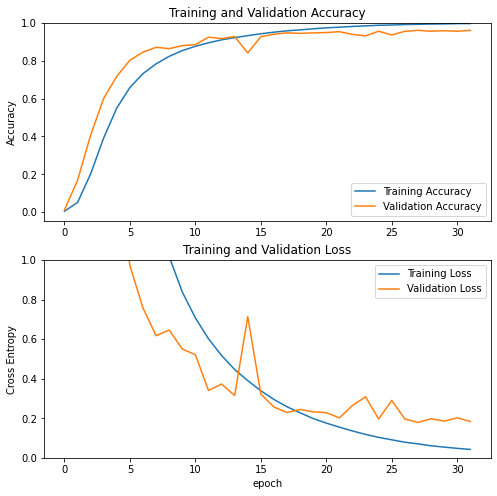

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [36]:
conv_base.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(conv_base.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in conv_base.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(loss='sparse_categorical_crossentropy', 
              optimizer = tf.keras.optimizers.RMSprop(learning_rate = 1e-6),
              metrics=['accuracy'])
model.summary()

Number of layers in the base model:  237
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb0 (Functional)  (None, 7, 7, 1280)        4049571   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 1280)              5120      
_________________________________________________________________
top_dropout (Dropout)        (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1049)              1343769   
Total params: 5,398,460
Trainable params: 5,186,677
Non-trainable params: 211,783
_________________________________________________________________


In [37]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds_ag,
                         epochs=total_epochs,
                         initial_epoch = history.epoch[-1],
                         callbacks=[es, mc],
                         validation_data=val_ds)

Epoch 32/42
17621/17621 [==============================] - 927s 52ms/step - loss: 0.0426 - accuracy: 0.9960 - val_loss: 0.1776 - val_accuracy: 0.9614
Epoch 33/42
17621/17621 [==============================] - 915s 52ms/step - loss: 0.0425 - accuracy: 0.9967 - val_loss: 0.1759 - val_accuracy: 0.9623
Epoch 34/42
17621/17621 [==============================] - 903s 51ms/step - loss: 0.0466 - accuracy: 0.9966 - val_loss: 0.1763 - val_accuracy: 0.9610
Epoch 35/42
17621/17621 [==============================] - 912s 52ms/step - loss: 0.0480 - accuracy: 0.9973 - val_loss: 0.1753 - val_accuracy: 0.9612
Epoch 36/42
17621/17621 [==============================] - 909s 52ms/step - loss: 0.0525 - accuracy: 0.9968 - val_loss: 0.1758 - val_accuracy: 0.9610
Epoch 37/42
17621/17621 [==============================] - 906s 51ms/step - loss: 0.0570 - accuracy: 0.9971 - val_loss: 0.1771 - val_accuracy: 0.9608
Epoch 38/42
17621/17621 [==============================] - 912s 52ms/step - loss: 0.0631 - accuracy:

In [38]:
test_ds = tf.data.Dataset.from_tensor_slices((test_img_list))
test_ds = test_ds.map(lambda x: (process_path(x)), AUTOTUNE)
test_ds = test_ds.batch(batch_size).prefetch(AUTOTUNE)

In [39]:
preds = model.predict(test_ds,verbose=1)
pred_labels = np.argmax(preds, axis=1)
pred_probs = np.array([pred[indice] for pred, indice in zip(preds, pred_labels)])

9491/9491 [==============================] - 130s 14ms/step


In [40]:
submission_df.head()

,id,landmark_id,conf
0,xlf1tgh2ih,1,1
1,68a3ot4osk,1,1
2,si2lek4u0a,1,1
3,rmtqxhipnv,1,1
4,2flmjdud0e,1,1


In [41]:
test_img_list[0][13:-4]

'000b85kx5d'

In [42]:
test_img_id = [img[13:-4] for img in test_img_list]

In [43]:
test_img_id[0]

'000b85kx5d'

In [44]:
np.array([test_img_id, pred_labels, pred_probs])

array([['000b85kx5d', '002msp5aqm', '003pjobcd8', ..., 'zzxg4eqox1',
        'zzxtgfn0xp', 'zzz3w4hsr6'],
       ['846', '7', '378', ..., '140', '25', '315'],
       ['0.9999975', '0.99962664', '0.9999871', ..., '0.9999993',
        '0.74552965', '0.99810094']], dtype='<U32')

In [45]:
df_dict = {}
df_dict['id'] = test_img_id
df_dict['landmark_id'] = pred_labels
df_dict['conf'] = pred_probs

submission = pd.DataFrame.from_dict(df_dict)
submission.head()

,id,landmark_id,conf
0,000b85kx5d,846,0.999997
1,002msp5aqm,7,0.999627
2,003pjobcd8,378,0.999987
3,006r4lemjl,252,0.999997
4,007kjoke4f,809,0.999936


In [46]:
submission.loc[submission['id']=='xlf1tgh2ih',:]

,id,landmark_id,conf
35456,xlf1tgh2ih,956,0.99743


In [47]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37964 entries, 0 to 37963
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           37964 non-null  object 
 1   landmark_id  37964 non-null  int64  
 2   conf         37964 non-null  float32
dtypes: float32(1), int64(1), object(1)
memory usage: 741.6+ KB


In [49]:
submission.to_csv('./finetuning_landmark_mobilenet.csv',index=False)